### Basic imports (TODO: move to a python file?)

In [7]:
import pickle
from diffusion.sampling import *
from diffusion.likelihood import mmff_energy
#from rdkit.Chem.Draw import IPythonConsole
#IPythonConsole.ipython_useSVG=True 
import py3Dmol
from rdkit import Chem, Geometry
#from ipywidgets import interact, Dropdown
import matplotlib.pyplot as plt
from rdkit.Chem import rdMolAlign 
#from termcolor import colored 
from rdkit.Chem import rdMolTransforms
from utils.standardization import fast_rmsd
from torch_geometric.data import Data, Batch
import tqdm 
from torch.utils.data import Subset 
import time 
from diffusion.sampling import get_seed, embed_seeds
from utils.dataset import make_dataset_from_smi
from gflownet.gfn_metrics import get_2dheatmap_array_and_pt 
from utils.torsion import get_rotatable_ta_list 
import pandas as pd


/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_geometric/typing.py:99: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(
/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [1]:
def get_bond_lengths(mol):
    assert mol.GetNumConformers() == 1    
    bond_lengths = []
    for bond in mol.GetBonds():
        bond_lengths.append(rdMolTransforms.GetBondLength(mol.GetConformer(),bond.GetBeginAtom().GetIdx(), bond.GetEndAtom().GetIdx() ) )
    return torch.Tensor(bond_lengths)

def get_bond_angles(mol):
    assert mol.GetNumConformers() == 1
    bond_angles = []
    for bond in mol.GetBonds():
        atom1 = bond.GetBeginAtom()
        atom2 = bond.GetEndAtom()
        for neighbor in atom2.GetNeighbors():
            if neighbor.GetIdx() != atom1.GetIdx():
                angle = rdMolTransforms.GetAngleRad(mol.GetConformer(),   
                                                    atom1.GetIdx(), 
                                                    atom2.GetIdx(), 
                                                    neighbor.GetIdx())
                bond_angles.append(angle)
    return torch.Tensor(bond_angles)

def get_torsion_angles(mol):
    assert mol.GetNumConformers() == 1
    torsion_angles = []
    for bond in mol.GetBonds():
        atom1 = bond.GetBeginAtom()
        atom2 = bond.GetEndAtom()
        
        # Get neighboring atoms
        for neighbor1 in atom2.GetNeighbors():
            if neighbor1.GetIdx() != atom1.GetIdx():
                # Calculate the angle
                for neighbor2 in neighbor1.GetNeighbors():
                    if neighbor2.GetIdx() != atom2.GetIdx() and neighbor2.GetIdx() != atom1.GetIdx():
                        torsion = rdMolTransforms.GetDihedralRad(mol.GetConformer(), 
                                                                 atom1.GetIdx(), 
                                                                 atom2.GetIdx(), 
                                                                 neighbor1.GetIdx(), 
                                                                 neighbor2.GetIdx())
                        torsion_angles.append(torsion)
    return torch.Tensor(torsion_angles)

def get_means_and_stds_internal_coords(mols):
    
    all_bond_lengths = [get_bond_lengths(mol) for mol in mols]
    all_bond_angles = [get_bond_angles(mol) for mol in mols]
    all_torsion_angles = [get_torsion_angles(mol) for mol in mols]
    bond_lengths_mean, bond_lengths_std =  torch.stack(all_bond_lengths).mean(dim=0) , torch.stack(all_bond_lengths).std(dim=0)
    bond_angles_mean  , bond_angles_std =   torch.stack(all_bond_angles).mean(dim=0) , torch.stack(all_bond_angles).std(dim=0)
    torsion_angles_mean , torsion_angles_std =  torch.stack(all_torsion_angles).mean(dim=0)  , torch.stack(all_torsion_angles).std(dim=0)
    return bond_lengths_mean, bond_angles_mean, torsion_angles_mean, bond_lengths_std, bond_angles_std, torsion_angles_std

def get_rmsds(mols, mols_optimized):
    '''
    This function compares a set of molecules with their optimized versions and returns the RMSDs between each pair (non-optimized, optimized).
    '''
    rmsds = []
    for conf_idx in range(len(mols)):
        mol0, mol1 = mols[conf_idx], mols_optimized[conf_idx]
        rdMolAlign.AlignMol(mol0, mol1)
        rmsds.append(fast_rmsd(mol0, mol1 , conf1=0, conf2=0) )
    return rmsds 



In [2]:
def set_bond_lengths(mol, ref_mol):
    new_mol = copy.deepcopy(mol)
    assert new_mol.GetNumConformers() == 1    
    for bond in mol.GetBonds():
        if bond.IsInRing() == False:
            new_bond_length = rdMolTransforms.GetBondLength(ref_mol.GetConformer(),bond.GetBeginAtom().GetIdx(), bond.GetEndAtom().GetIdx() )
            rdMolTransforms.SetBondLength(new_mol.GetConformer(), bond.GetBeginAtom().GetIdx(), bond.GetEndAtom().GetIdx(), new_bond_length )
    return new_mol

def set_bond_angles(mol, ref_mol):
    new_mol = copy.deepcopy(mol)
    assert mol.GetNumConformers() == 1
    for bond in mol.GetBonds():
        atom1 = bond.GetBeginAtom()
        atom2 = bond.GetEndAtom()
        for neighbor in atom2.GetNeighbors():
            if neighbor.GetIdx() != atom1.GetIdx():
                if not (atom1.IsInRing() and atom2.IsInRing() and neighbor.IsInRing() ):
                    new_angle = rdMolTransforms.GetAngleRad(ref_mol.GetConformer(),   
                                                        atom1.GetIdx(), 
                                                        atom2.GetIdx(), 
                                                        neighbor.GetIdx())
                    rdMolTransforms.SetAngleRad(new_mol.GetConformer(),   
                                                        atom1.GetIdx(), 
                                                        atom2.GetIdx(), 
                                                        neighbor.GetIdx(), new_angle)
    return new_mol

In [3]:
def plot_aligned_confs(mols):
    #for conf in data:
        #mol = pyg_to_mol(conf.mol, conf, mmff=False, rmsd=False, copy=True)
        #mols.append(mol)
    # align all mols to the first one
    for i in range(1, len(mols)):
        rdMolAlign.AlignMol(mols[i], mols[0])
    # Plot mols
    ## Convert to mol blocks
    mol_blocks = [Chem.MolToMolBlock(mol) for mol in mols]

    colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta', 'pink', 'brown', 'grey', 'black', 'white', 'salmon', 'olive', 'lime', 'teal', 'indigo', 'violet', 'tan', 'khaki', 'gold', 'coral', 'azure', 'lavender', 'orchid', 'plum', 'crimson', 'maroon', 'sienna', 'navy', 'skyblue', 'turquoise', 'aquamarine', 'mint', 'lime', 'chartreuse', 'olive', 'khaki', 'gold', 'coral', 'salmon', 'tomato', 'orangered', 'firebrick', 'maroon', 'sienna', 'chocolate', 'saddlebrown', 'brown', 'black', 'grey', 'dimgray', 'darkgray', 'silver', 'lightgray', 'gainsboro', 'white']
    view = py3Dmol.view(width=400, height=400)
    for i, mol_block in enumerate(mol_blocks):
        view.addModel(mol_block, "mol")
        view.setStyle({'model': i}, {'stick': {'color': colors[i%len(colors)]}})

    view.addLabel('confs',{'position': {'x': 0, 'y': 8, 'z': 0}, 
                'backgroundColor': 'white', 
                'fontColor': 'black', 
                'fontSize': 16, 
                'alignment': 'topCenter'})
    view.zoomTo()
    view.show()

In [4]:
def get_rmsd_torsiondist(data,ix0, ix1):
    '''
    Get 2D rmsd heatmap and 2D torsion_angles dists heatmap
    '''
    torsion_angles_linspace = torch.linspace(0, 2*np.pi, 100)
    rmsds = []
    torsion_angles_dists = []
    for theta0 in torsion_angles_linspace:
        rmsds.append([])
        torsion_angles_dists.append([])
        for theta1 in torsion_angles_linspace:
            data0 = copy.deepcopy(data)
            torsion_update = np.zeros(len(data0.mask_rotate))
            torsion_update[ix0], torsion_update[ix1] = theta0, theta1
            new_pos = modify_conformer(data0.pos, data0.edge_index.T[data0.edge_mask], data0.mask_rotate, torsion_update, as_numpy=False) #change the value of the 1st torsion angle
            data0.pos = new_pos
            mol0 = pyg_to_mol(data0.mol, data0, mmff=False, rmsd=True, copy=True)
            mol = pyg_to_mol(data.mol, data, mmff=False, rmsd=True, copy=True)
            rmsds[-1].append(fast_rmsd(mol0, mol, conf1=0, conf2=0))
            torsion_angles_dists[-1].append(min(theta1, 2 * np.pi - theta1) + min(theta0, 2 * np.pi - theta0))  
            
    return rmsds, torsion_angles_dists

In [5]:
def embed_func(mol, numConfs):
    AllChem.EmbedMultipleConfs(mol, numConfs=numConfs, numThreads=5)
    return mol

In [6]:
def set_positions(mol, positions):
    new_mol = copy.deepcopy(mol)
    for atom_idx, pos in enumerate(positions):
        new_mol.GetConformer().SetAtomPosition(atom_idx, Geometry.Point3D(pos[0], pos[1], pos[2]))
    return new_mol

### Explore freesolv

In [9]:
freesolv_df = pd.read_csv('data/freesolv_79smis_1_confs.csv')
freesolv_df = freesolv_df[~freesolv_df['smiles'].isin([ ' c1cc(ccc1[N+](=O)[O-])O', ' CC[C@@H](C)CO' , ' C[C@@H](CO[N+](=O)[O-])O[N+](=O)[O-]' , ' CCCC[N+](=O)[O-]', ' CC(=O)CO[N+](=O)[O-]', ' Cc1cccc(c1)[N+](=O)[O-]', ' CC[N+](=O)[O-]'])]
# remove this mol cause doesn't have md sim
smis = list(set(freesolv_df['smiles'].tolist()))
print('len of dataset, ' , len(smis))
limit_mols = 53
' '.join(smis[:limit_mols])

len of dataset,  72


' C[C@@H]1CCCC[C@@H]1C  CCCCCCCCC=O  CCOC(=O)c1ccccc1  CCOCCO  CC(C)(C)Br  COC(=O)C(F)(F)F  CCOC(=O)c1ccc(cc1)O  CCC[C@@H](C)O  CCCC(C)(C)C  CCC  CCCCCCCC(=O)OC  CCOP(=O)(OCC)OCC  c1ccc(c(c1)C(F)(F)F)C(F)(F)F  CC(C)COC(=O)C  c1cc(cc(c1)O)C#N  c1ccc(cc1)CCCO  CN(C)C(=O)Nc1ccccc1  CCCc1ccccc1  CC(C)(C)C  CC(=CCC/C(=C/CO)/C)C  COc1ccccc1N  CC(C)C=C  C[C@H](CC(C)C)O  C1C=CC[C@@H]2[C@@H]1C(=O)N(C2=O)SC(Cl)(Cl)Cl  CC=C(C)C  c1ccc(cc1)O[C@@H](C(F)F)F  CCC(C)CC  CC(=C)C=C  CC[C@H](C(C)C)O  CCCCCCl  CCCCOCCCC  CCCCCCCC(=O)C  C1[C@H]([C@@H]([C@H]([C@H](O1)O)O)O)O  CC[C@H](C)O  CCCCCCN  CC(C)(C)C(=O)OC  CC(C)OC(C)C  C([C@H]([C@H]([C@@H]([C@@H](CO)O)O)O)O)O  CCSC  c1ccc2c(c1)C(=O)c3c(ccc(c3C2=O)N)N  CC(=O)Oc1ccccc1C(=O)O  CCc1cccc2c1cccc2  CCCc1ccc(c(c1)OC)O  COc1ccccc1OC  CCCOCCC  CCCCCBr  CC(=C)c1ccccc1  CC(C)c1ccccc1  CC(C)(/C=N\\OC(=O)NC)SC  COC=O  Cn1cnc2c1c(=O)n(c(=O)n2C)C  CCOC(=O)CCC(=O)OCC  CC(C)CCO'

In [10]:
def get_info(smis):
    num_heavy_atoms = [] 
    num_atoms = [] 
    num_torsion_angles = [] 
    valid_smis = []
    min_n_torsion = 1
    for smi in tqdm.tqdm(smis): 
        mol, data = get_seed(smi)
        if mol is None:
            pass
        #elif hasattr(data, 'mask_rotate') == False or data.mask_rotate.shape[0] < min_n_torsion:
        elif len(get_rotatable_ta_list(mol)) < min_n_torsion:
                pass
        else:
            num_heavy_atoms.append(mol.GetNumHeavyAtoms())
            num_atoms.append(mol.GetNumAtoms())
            num_torsion_angles.append(len(get_rotatable_ta_list(mol)))
            valid_smis.append(smi)

    num_heavy_atoms, num_atoms, num_torsion_angles = np.array(num_heavy_atoms), np.array(num_atoms), np.array(num_torsion_angles)
    valid_smis = np.array(valid_smis)
    print(f'Processable smiles: {len(valid_smis)} out of {len(smis)}')
    return num_heavy_atoms, num_atoms, num_torsion_angles, valid_smis


num_heavy_atoms, num_atoms, num_torsion_angles, valid_smis = get_info(smis)
#pickle.dump(valid_smis, open('freesolv_valid_smis.pkl', 'wb'))
#conformers, pdb = embed_seeds(mol, data, n_confs=32, single_conf=False, pdb=None, embed_func=embed_func, mmff=False)



100%|██████████| 72/72 [00:00<00:00, 153.02it/s]

Processable smiles: 72 out of 72


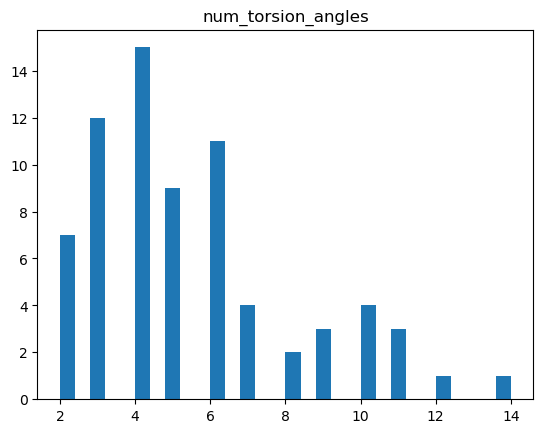

In [44]:
plt.hist(num_torsion_angles, bins=30)
plt.title("num_torsion_angles")
plt.show()

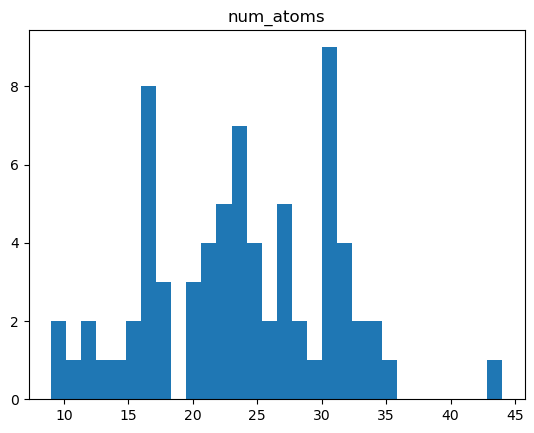

In [46]:
plt.hist(num_atoms, bins=30)
plt.title("num_atoms")
plt.show()

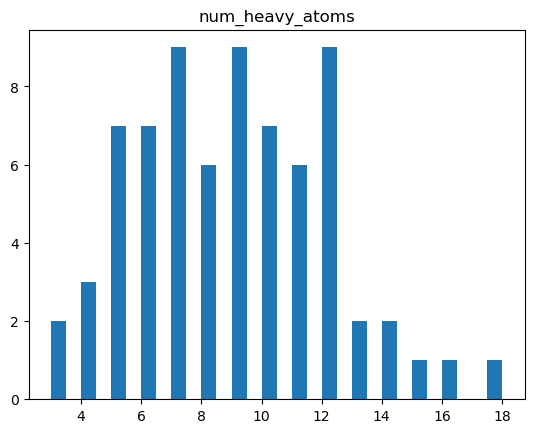

In [47]:
plt.hist(num_heavy_atoms, bins=30)
plt.title("num_heavy_atoms")
plt.show()

### FreeSolv eval plots

In this section, we define functions for making a histogram of energies, tica plots, and histograms distribution of bond lengths/bond angles/torsion angles/ visualizing energy plots vs logpT plots

In [ ]:
freesolv_df = pd.read_csv('data/freesolv_79smis_1_confs.csv')
freesolv_df = freesolv_df[~freesolv_df['smiles'].isin([ ' c1cc(ccc1[N+](=O)[O-])O', ' CC[C@@H](C)CO' , ' C[C@@H](CO[N+](=O)[O-])O[N+](=O)[O-]' , ' CCCC[N+](=O)[O-]', ' CC(=O)CO[N+](=O)[O-]', ' Cc1cccc(c1)[N+](=O)[O-]', ' CC[N+](=O)[O-]', ' CCOP(=S)(OCC)S[C@@H](CCl)N1C(=O)c2ccccc2C1=O',
 ' CCOP(=S)(OCC)Oc1ccc(cc1)[N+](=O)[O-]',
 ' CCCC[N@](CC)c1c(cc(cc1[N+](=O)[O-])C(F)(F)F)[N+](=O)[O-]',
 ' CCOC(=O)C[C@H](C(=O)OCC)SP(=S)(OC)OC',
 ' CCN(CC)c1c(cc(c(c1[N+](=O)[O-])N)C(F)(F)F)[N+](=O)[O-]',
 ' CCCN(CCC)c1c(cc(cc1[N+](=O)[O-])S(=O)(=O)C)[N+](=O)[O-]',
 ' CCCN(CCC)c1c(cc(cc1[N+](=O)[O-])C(F)(F)F)[N+](=O)[O-]'
 ])]
# remove this mol cause doesn't have md sim
limit_mols = 72
smis_train, smis_test = list(set(freesolv_df['smiles'].tolist()))[:limit_mols], list(set(freesolv_df['smiles'].tolist()))[limit_mols:]
print('len of dataset, ' , len(smis_train), len(smis_test))
smis_with_2_tas = np.array(smis_train)[np.where(num_torsion_angles == 2)]

len of dataset,  72 0


In [9]:
'''
k_b = 0.001987204118 
room_temp = 298.15
T = k_b * room_temp

# suppose we have the dictionaries logrews_md, mols_md and pos_md

md_trajs_dict = pickle.load(open('/home/mila/l/lena-nehale.ezzine/ai4mols/torsional-diffusion/data/mdtrajs_dict_reordered.pkl', 'rb'))
logrews_md = {smi: [] for smi in md_trajs_dict.keys()}
mols_md  = {smi: [] for smi in md_trajs_dict.keys()}
for smi in md_trajs_dict.keys():
    try:
        mol, data = get_seed(smi)
        AllChem.EmbedMultipleConfs(mol, numConfs=1)
        for i, pos in enumerate(md_trajs_dict[smi]):
            new_mol = set_positions(mol, 10 * pos.astype('double')) # Careful: the units of md simulations positions is in nanometers, while the expected unit for rdkit molecules is angstroms 
            mols_md[smi].append(new_mol)
            logrews_md[smi].append( - mmff_energy(new_mol) / T)
        
        logrews_md[smi] = torch.Tensor(logrews_md[smi])
    except:
        print('smi ', smi)
pickle.dump(logrews_md, open('data/logrews_md.pkl', 'wb'))
pickle.dump(mols_md, open('data/mols_md.pkl', 'wb'))
plot_aligned_confs(mols_md[smis_train[0]][-8:-4])
'''

"\nk_b = 0.001987204118 \nroom_temp = 298.15\nT = k_b * room_temp\n\n# suppose we have the dictionaries logrews_md, mols_md and pos_md\n\nmd_trajs_dict = pickle.load(open('/home/mila/l/lena-nehale.ezzine/ai4mols/torsional-diffusion/data/mdtrajs_dict_reordered.pkl', 'rb'))\nlogrews_md = {smi: [] for smi in md_trajs_dict.keys()}\nmols_md  = {smi: [] for smi in md_trajs_dict.keys()}\nfor smi in md_trajs_dict.keys():\n    try:\n        mol, data = get_seed(smi)\n        AllChem.EmbedMultipleConfs(mol, numConfs=1)\n        for i, pos in enumerate(md_trajs_dict[smi]):\n            new_mol = set_positions(mol, 10 * pos.astype('double')) # Careful: the units of md simulations positions is in nanometers, while the expected unit for rdkit molecules is angstroms \n            mols_md[smi].append(new_mol)\n            logrews_md[smi].append( - mmff_energy(new_mol) / T)\n        \n        logrews_md[smi] = torch.Tensor(logrews_md[smi])\n    except:\n        print('smi ', smi)\npickle.dump(logrews_m

In [18]:
from utils.eval_plots import *
from utils.dataset import make_dataset_from_smi
from gflownet.gfn_train import gfn_sgd
import argparse
from diffusion.score_model import TensorProductScoreModel
from diffusion.sampling import perturb_seeds
from gflownet.gfn_train import get_logrew
from torch_geometric.data import Data, Batch
import pickle
from copy import deepcopy

# load params
## general model params
device = torch.device('cuda')
sigma_min = 0.01 * np.pi
sigma_max = np.pi
## energy params
energy_fn = 'mmff'
seed = 0
k_b = 0.001987204118 
room_temp = 298.15
T = k_b * room_temp
logrew_clamp = -1e5

def load_model(exp_path):
    model = TensorProductScoreModel(in_node_features=74, in_edge_features=4,
                                    sigma_embed_dim=32,
                                    num_conv_layers=4,
                                    max_radius=5.0, radius_embed_dim=50,
                                    scale_by_sigma=True,
                                    use_second_order_repr=False,
                                    residual=True, batch_norm=True)


    model_path = "/home/mila/l/lena-nehale.ezzine/scratch/torsionalGFNmodel_chkpts"

    model_dir = f"{model_path}/{exp_path}.pt"
    state_dict = torch.load(f'{model_dir}', map_location= torch.device('cuda'))
    model.load_state_dict(state_dict, strict=True)
    model = model.to(device)
    model.eval()
    return model


def generate_stuff(model, smis, n_smis_batch = 10): 
    
    
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    logrews_gen_all = {}
    pos_gen = {}
    mols_gen = {}
    num_tas = {}

    logrews_rand = {}
    pos_rand = {}
    mols_rand = {}
    
    logZs_hat = []


    n_smis = len(smis)

    for i in range(n_smis // n_smis_batch):
        smis_subset = smis[n_smis_batch * i : n_smis_batch * (i + 1) ]
        print('smis subset', smis_subset)
        confs_rdkit_from_smi = make_dataset_from_smi(smis_subset)
        train_loss, conformers_gen_subset, logit_pfs, logit_pbs, logrews_gen_subset, perturbs, trajs = gfn_sgd(model, 
                                                                                    confs_rdkit_from_smi  , 
                                                                                    optimizer, 
                                                                                    device,  
                                                                                    sigma_min = sigma_min, 
                                                                                    sigma_max = sigma_max, 
                                                                                    steps = diffusion_steps, 
                                                                                    train=False, 
                                                                                    batch_size = batch_size,
                                                                                    T=T, 
                                                                                    logrew_clamp = logrew_clamp, 
                                                                                    energy_fn = energy_fn, 
                                                                                    train_mode='gflownet', 
                                                                                    use_wandb = False, 
                                                                                    ReplayBuffer = None, 
                                                                                    p_expl = p_expl, 
                                                                                    p_replay = p_replay, 
                                                                                    grad_acc = False)


        conformers_gen_subset = {smi: item for smi, item in zip(smis_subset, conformers_gen_subset)}
        logrews_gen_all.update({smi: logrew.cpu() for smi, logrew in zip(smis_subset,logrews_gen_subset ) })
        
        mols_gen.update({smi: [pyg_to_mol(conf.mol, conf, mmff=False, rmsd=False, copy=True) for conf in confs] for smi, confs in conformers_gen_subset.items() })
        pos_gen.update({smi: np.array([conf.pos.cpu().numpy() for conf in confs ]) for smi, confs in conformers_gen_subset.items()})

        
        conformers_rand_subset = {smi: perturb_seeds(deepcopy(confs)) for smi, confs in conformers_gen_subset.items()} 
        logrews_rand.update({ smi: get_logrew(Batch.from_data_list(confs), T , energy_fn = energy_fn, clamp = logrew_clamp).cpu() for  smi, confs in conformers_rand_subset.items()})
        pos_rand.update({smi: np.array([conf.pos.cpu().numpy() for conf in confs ]) for smi, confs in  conformers_rand_subset.items() })
        mols_rand.update({smi: [pyg_to_mol(conf.mol, conf, mmff=False, rmsd=False, copy=True) for conf in confs] for smi, confs in conformers_rand_subset.items() })

            
        num_tas.update({smi: len(confs[0].mask_rotate)  for smi, confs in  conformers_rand_subset.items()   })


        logZ = torch.logsumexp(torch.stack(logit_pbs) + torch.stack(logrews_gen_subset) - torch.stack(logit_pfs), dim = 1) - np.log(len(logit_pfs[0])).item() #TODO verifier qu'on rajoute la bonne constante?
        logZ = logZ - np.log(sigma_min).item() + np.log(sigma_max).item()
        logZs_hat.append(logZ)
        

    pos_md, logrews_md, mols_md = pickle.load(open("data/mdtrajs_dict_reordered.pkl", 'rb')), pickle.load(open("data/logrews_md.pkl", 'rb')), pickle.load(open("data/mols_md.pkl", 'rb'))
    pos_md = {smi:pos_md[smi] for smi in smis}
    logrews_md = {smi:logrews_md[smi] for smi in smis}
    mols_md = {smi:mols_md[smi] for smi in smis}
    logZs_md = [torch.logsumexp(logrews_md[smi] / len(logrews_md[smi]), dim = 0)  for smi in smis]
    logZs_hat = torch.stack(logZs_hat)
    
    for smi in smis:
        try:
            print('###################')
            print(f'logrew medians for {smi}: rand {logrews_rand[smi].median()} gen {logrews_gen_all[smi].median()} md {logrews_md[smi].median()} ' )
            print(f'logrew means for {smi}: rand {logrews_rand[smi].mean()} gen {logrews_gen_all[smi].mean()} md {logrews_md[smi].mean()} ')
        except:
            pass

    assert len(logrews_rand) == len(logrews_gen_all) == len(logrews_md)
    assert len(pos_rand) == len(pos_gen) == len(pos_md)
    assert len(mols_rand) == len(mols_gen) == len(mols_md)
    
    return {'logrews': [logrews_rand, logrews_gen_all, logrews_md], 'positions': [pos_rand, pos_gen, pos_md], 'mols': [mols_rand, mols_gen, mols_md], 'num_tas': num_tas,   'logZs': [logZs_md, logZs_hat]} 




In [19]:
torch.cuda.empty_cache()
energy_fn, seed, p_replay, p_expl, diffusion_steps = 'mmff', 0, 0.2, 0.2, 20
diffusion_steps, batch_size, p_expl, p_replay, smis = 20, 1024, 0.2, 0.2, smis_train[80:]

exp_path = f"gflownet_{energy_fn}_{seed}_limit_train_mols_80_dataset_freesolv_p_replay_{p_replay}_p_expl_{p_expl}"


model = load_model(exp_path)

#generated_stuff = generate_stuff(model, smis, n_smis_batch = 10)

/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type anno

In [ ]:
label = 'train'
# save stuff
logrews_path = f'/home/mila/l/lena-nehale.ezzine/scratch/TorsionalGFNgenerated_logrews'
positions_path = f'/home/mila/l/lena-nehale.ezzine/scratch/TorsionalGFNgenerated_positions'
if not os.path.exists(logrews_path):
    os.makedirs(logrews_path)
if not os.path.exists(positions_path):
    os.makedirs(positions_path)
pickle.dump(generated_stuff['logrews'], open(f'{logrews_path}/{exp_path}_{label}.pkl', 'wb')) # in case hist is not generated well
pickle.dump(generated_stuff['positions'], open(f'{positions_path}/{exp_path}_{label}.pkl', 'wb')) # for tica


logrews_rand, logrews_gen, logrews_md = generated_stuff['logrews']
pos_rand, pos_gen, pos_md = generated_stuff['positions']
mols_rand, mols_gen, mols_md = generated_stuff['mols']
num_tas = generated_stuff['num_tas']
logZ_hat, logZ_md = generated_stuff['logZs']

In [ ]:
len(logrews_rand), len(logrews_gen), len(logrews_md), len(pos_rand), len(pos_gen), len(pos_md), len(mols_rand), len(mols_gen), len(mols_md), len(num_tas)

(10, 10, 10, 10, 10, 10, 10, 10, 10, 10)

In [ ]:
def make_logrew_histograms(logrews_random, logrews_gen, logrews_gt, exp_path, label, range = 2):
    '''
    Plots histograms of logrews for generated, ground truth and random conformers, for the same set of smis.
    Args:
        - logrews_gen: dictionary where keys are smiles and values are tensors of logrews for generated conformers
        - logrews_gt: dictionary where keys are smiles and values are tensors of logrews for ground truth conformers
        - logrews_random: dictionary where keys are smiles and values are tensors of logrews for random conformers
    Returns:
        A figure of shape (n_smis // 5, 5) where each subplot coresponds to a different smile and shows the histograms of logrews for generated, ground truth and random conformers.

    '''
    
    assert logrews_gen.keys() == logrews_random.keys() == logrews_gt.keys()
    smis = logrews_gen.keys()
    n_smis = len(smis)
    n_subplots = 5 # number of subplots per row
    fig, axes = plt.subplots(max(n_smis // n_subplots, 1), n_subplots, figsize=(10, 5))
    if not isinstance(axes, np.ndarray):
        axes = np.array([[axes]])

    for smi_idx, smi in enumerate(smis):

        a , b = logrews_gt[smi].min().item() ,  logrews_gt[smi].max().item()
        range_min = a - range * (b - a)
        range_max = b + range * (b - a)
        n_bins = 100
        axes[ smi_idx // n_subplots , smi_idx % n_subplots ].hist(  logrews_random[smi], np.linspace(range_min, range_max, n_bins) , alpha=0.5, color='r', label = 'random', density=True)
        axes[ smi_idx // n_subplots , smi_idx % n_subplots ].hist(logrews_gen[smi], np.linspace(range_min, range_max, n_bins) , alpha=0.5, color='b', label = 'generated', density=True)
        axes[ smi_idx //n_subplots , smi_idx % n_subplots ].hist(logrews_gt[smi], np.linspace(range_min, range_max, n_bins) , alpha=0.5, color='g', label = 'ground truth', density=True)
        axes[smi_idx // n_subplots, smi_idx % n_subplots].set_title(smi)
        
        
    fig.suptitle('logrews distribution') 
    
    fig.legend(['random', 'generated','ground truth'], loc='upper right')
    plt.tight_layout() 
    plt.savefig(f"logrewshist_{exp_path}_{label}.png")
    plt.close(fig)

In [ ]:
make_logrew_histograms(logrews_rand, logrews_gen, logrews_md, exp_path, label)

In [113]:
logZ_hat

[tensor(7.5766),
 tensor(7.5284),
 tensor(7.5915),
 tensor(7.5770),
 tensor(7.5901),
 tensor(7.6503),
 tensor(7.5789),
 tensor(7.6794),
 tensor(7.5852),
 tensor(7.5864)]

In [114]:
logZ_md

tensor([[ -76.1439, -171.9466,  -77.7934,  -67.2082,  -92.3564, -114.5503,
          -52.5259,  139.7107, -144.2904, -248.8653]], device='cuda:0')

In [ ]:
from gflownet.gfn_train import get_logpT
def get_correlations(confs, model, sigma_min, sigma_max,  steps, device, num_trajs, n_subplots = 5): 
    '''
    Args:
    - confs: dictionary where keys are smiles and values are lists of pytorch geometric conformers
    '''
    logpTs = {}
    logrews = {}
    corrs = {}
    n_smis = confs.keys()
    fig, axes = plt.subplots(max(n_smis // n_subplots, 1), n_subplots, figsize=(10, 5))
    for smi_idx, smi in enumerate(confs.keys()):
        logpTs[smi] = [get_logpT(conf, model, sigma_min, sigma_max,  steps, device, ode=False, num_trajs = num_trajs).cpu().detach().numpy() for conf in confs[smi] ]
        logrews[smi] = [get_logrew(conf, T, energy_fn = energy_fn, clamp = logrew_clamp).cpu().numpy() for conf in confs[smi] ]
        corrs[smi] = np.corrcoef(logpTs[smi], logrews[smi])[0, 1]
        axes[ smi_idx // n_subplots , smi_idx % n_subplots ].scatter(logpTs[smi], logrews[smi])
        axes[ smi_idx // n_subplots , smi_idx % n_subplots ].set_title(smi)
    fig.suptitle('logpT vs logrews') 
    plt.tight_layout() 
    plt.savefig(f"correlations_{exp_path}_{label}.png")
    plt.close(fig)
    return corrs
        

Smi  C[C@@H]1CCCC[C@@H]1C


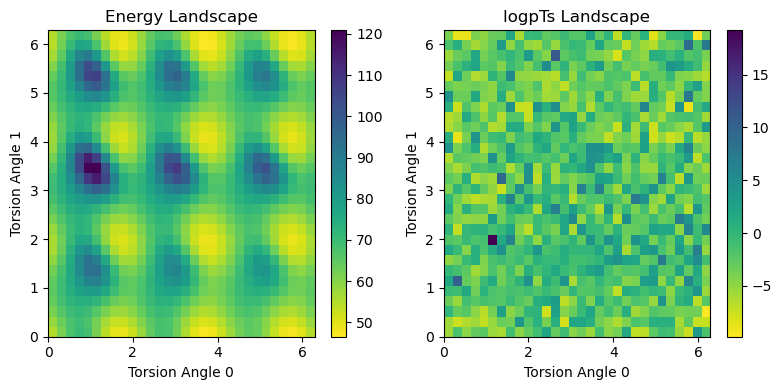

Smi  CCC


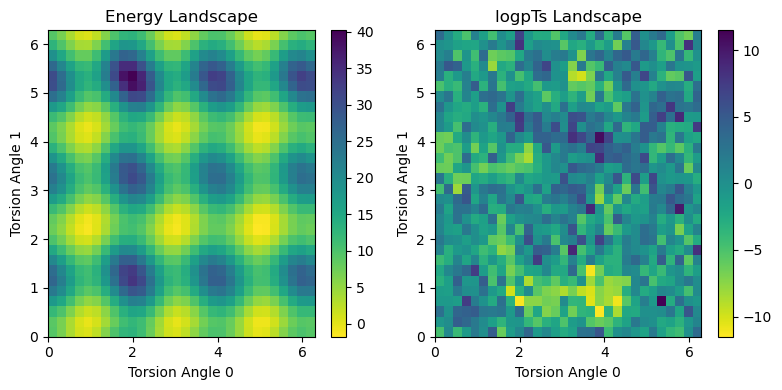

Smi  c1ccc(c(c1)C(F)(F)F)C(F)(F)F


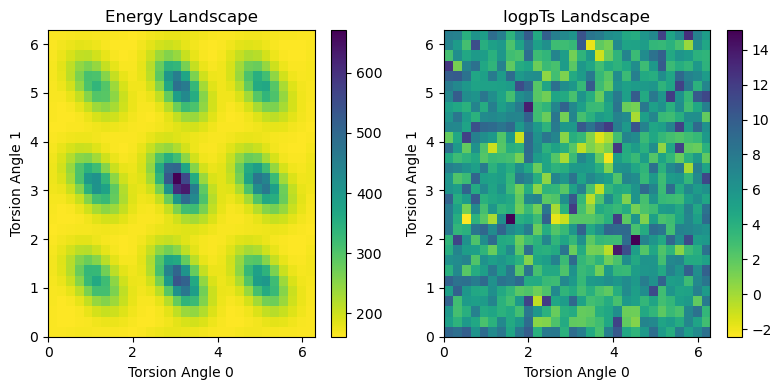

Smi  C1C=CC[C@@H]2[C@@H]1C(=O)N(C2=O)SC(Cl)(Cl)Cl


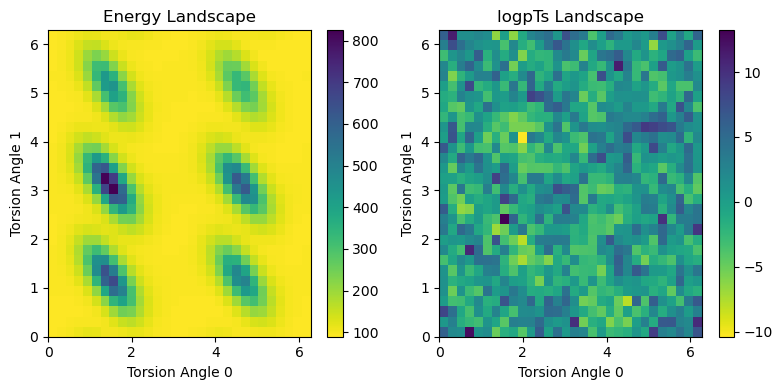

Smi  CC(=C)C=C


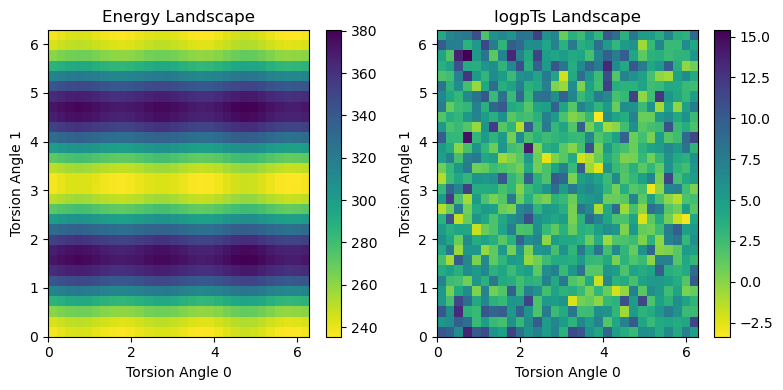

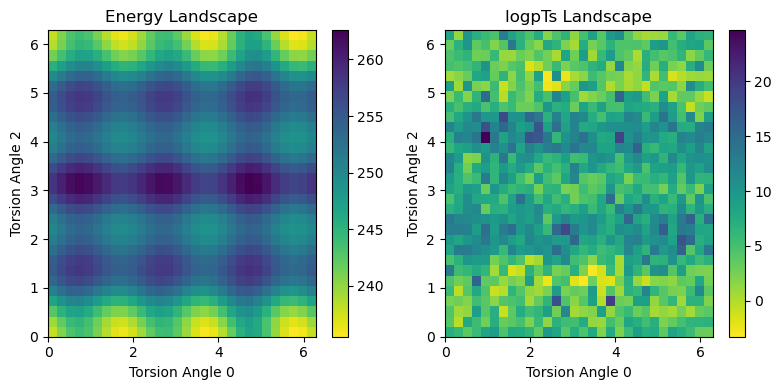

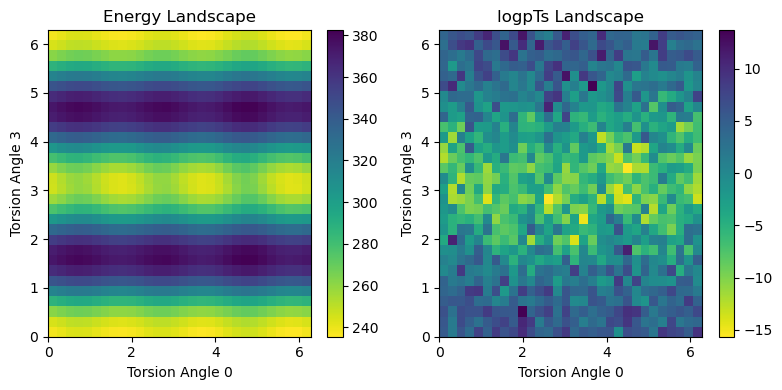

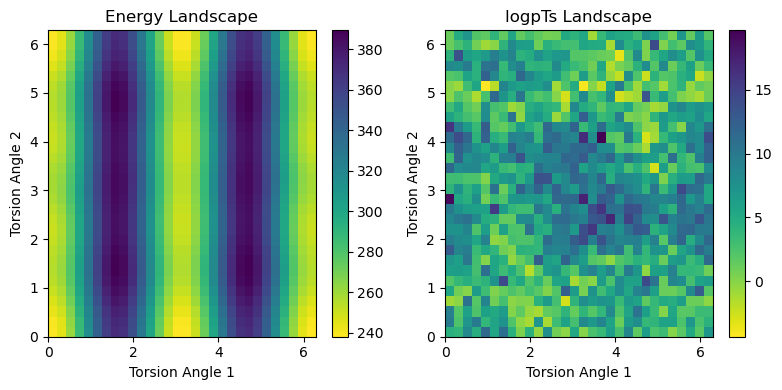

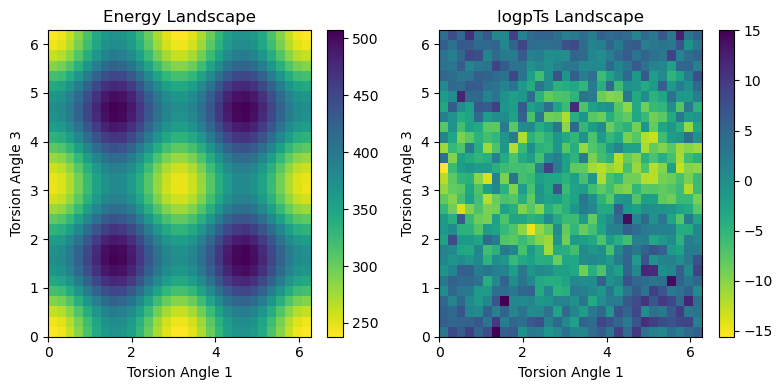

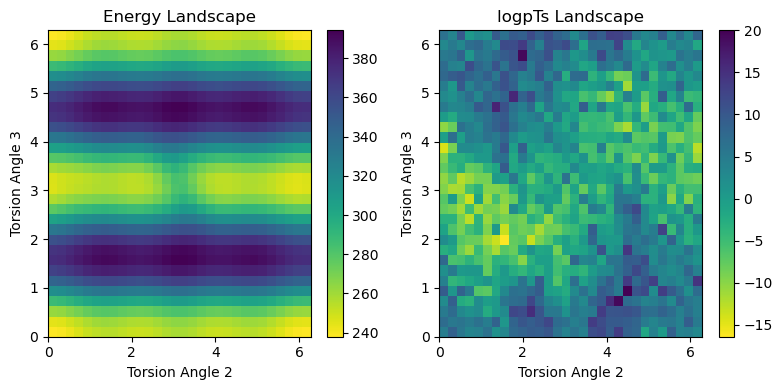

Smi  c1ccc2c(c1)C(=O)c3c(ccc(c3C2=O)N)N


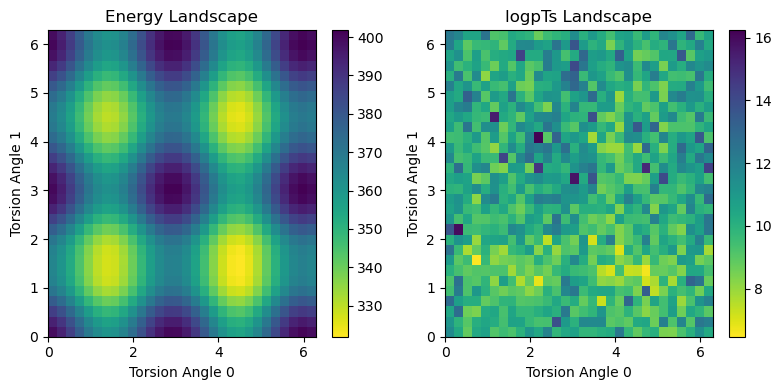

Smi  CCc1cccc2c1cccc2


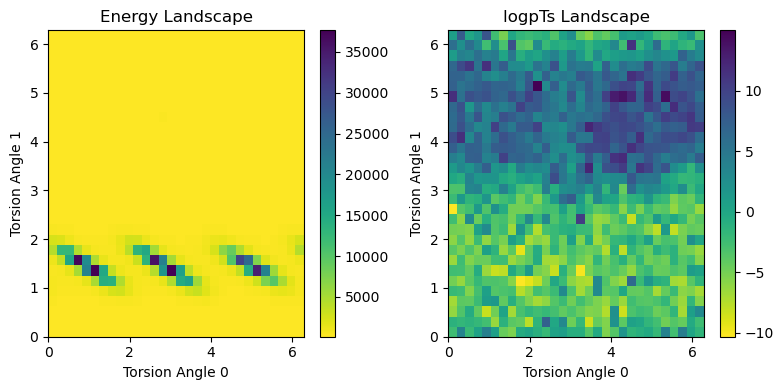

Smi  CC(=C)c1ccccc1


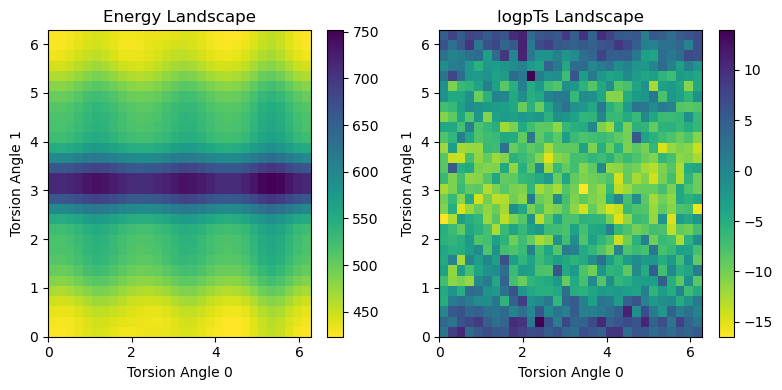

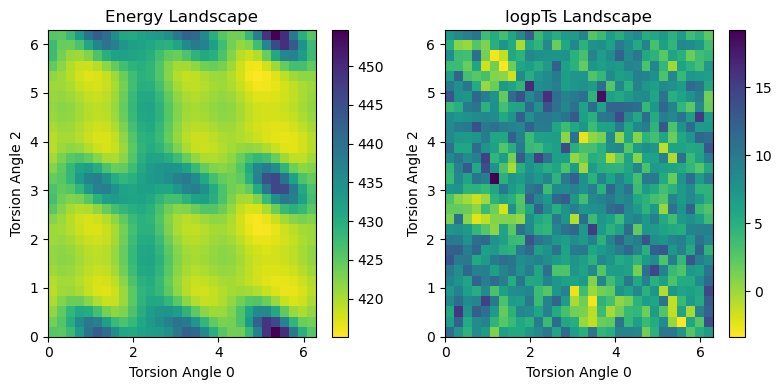

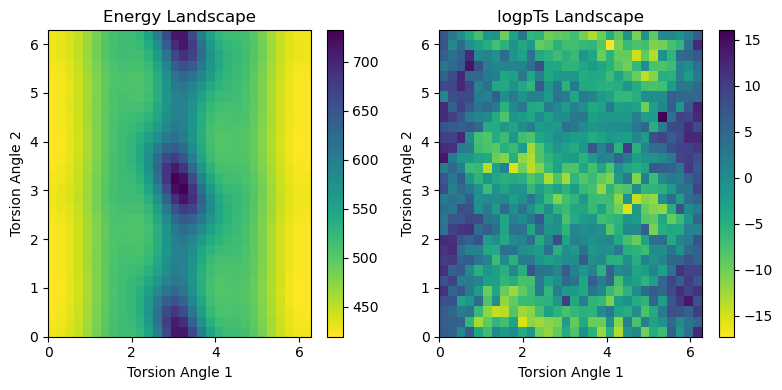

Smi  COC=O


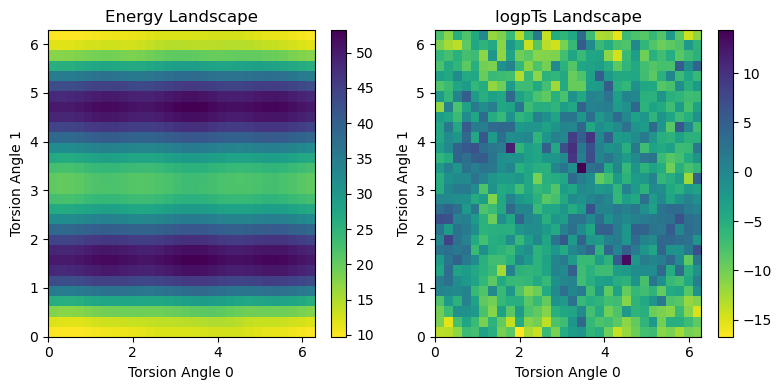

Smi  Cc1cc2ccccc2cc1C


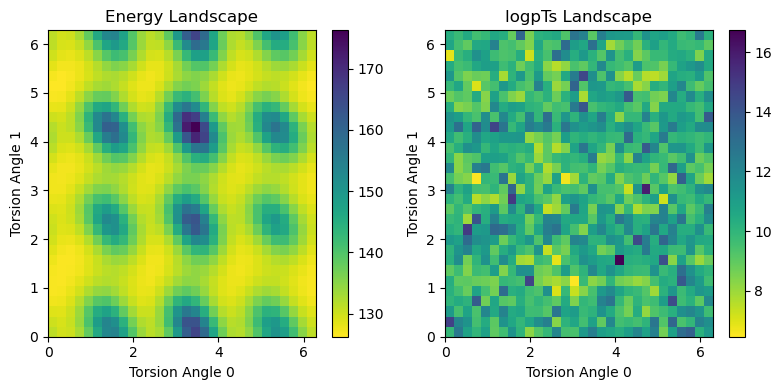

Smi  CCS


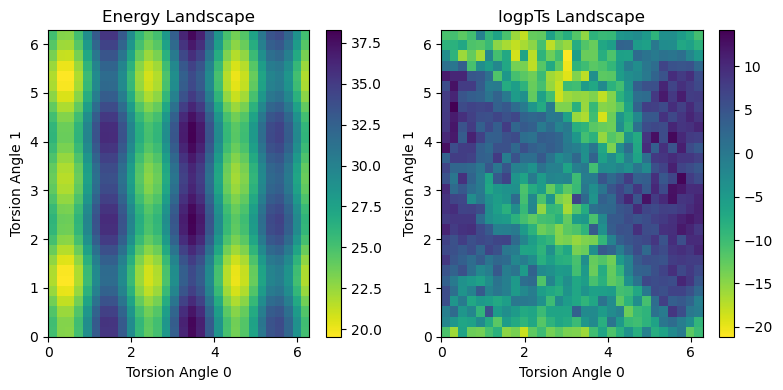

Smi  COc1ccccc1


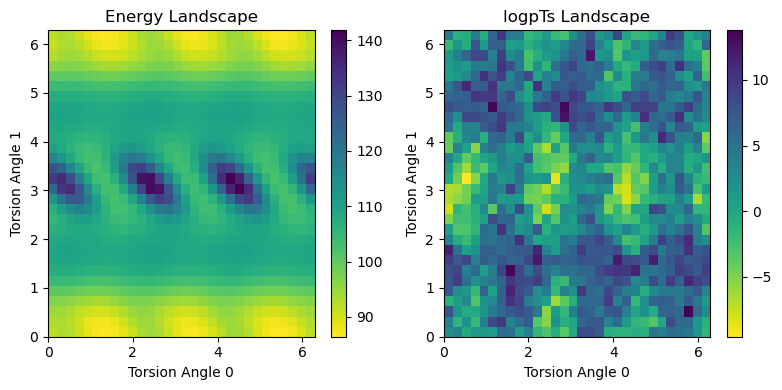

In [22]:
# Visualize the logpTs landscape vs the ground truth energy for a molecule with 2 torsion angles
import itertools
steps = 20
num_points = 30
num_trajs = 16
for smi in smis_with_2_tas:
    print('Smi', smi)
    data = make_dataset_from_smi([smi])[0]
    num_torsion_angles = len(data.mask_rotate)
    for ix0, ix1 in itertools.combinations(range(num_torsion_angles), 2):
        energy_landscape, logpTs = get_2dheatmap_array_and_pt(data, model, sigma_min, sigma_max,  steps, device, num_points, ix0 = ix0, ix1 = ix1, energy_fn = energy_fn, ode = False, num_trajs = num_trajs, T = T  , get_pt = True)


        fig, ax = plt.subplots(1, 2, figsize=(8, 4))

        # Plot energy landscape
        ax[0].imshow(np.array(energy_landscape).transpose() / T, extent=[0, 2 * np.pi, 0, 2 * np.pi], origin='lower', aspect='auto', cmap='viridis_r', vmin=np.min(energy_landscape) / T, vmax=np.max(energy_landscape) / T)
        ax[0].set_title('Energy Landscape')
        ax[0].set_xlabel(f'Torsion Angle {ix0}')
        ax[0].set_ylabel(f'Torsion Angle {ix1}')
        fig.colorbar(ax[0].images[0], ax=ax[0], orientation='vertical')
        
        # Plot logpTs
        ax[1].imshow(np.array(logpTs).transpose(), extent=[0, 2 * np.pi, 0, 2 * np.pi], origin='lower', aspect='auto', cmap='viridis_r', vmin=np.min(logpTs), vmax=np.max(logpTs))
        ax[1].set_title('logpTs Landscape')
        ax[1].set_xlabel(f'Torsion Angle {ix0}')
        ax[1].set_ylabel(f'Torsion Angle {ix1}')
        fig.colorbar(ax[1].images[0], ax=ax[1], orientation='vertical')
        plt.tight_layout()
        plt.show()

In [38]:
## distribution of bond lengths/bond angles / torsion angles for generated, ground truth and random conformers

In [42]:
smi = smis[0]
bond_angles = torch.stack([get_bond_angles(mol) for mol in mols_md[smi]]).flatten()
torsion_angles = torch.stack([get_torsion_angles(mol) for mol in mols_md[smi]]).flatten()
bond_lengths = torch.stack([get_bond_lengths(mol) for mol in mols_md[smi]]).flatten()

In [ ]:
def get_bond_lengths(mol):
    assert mol.GetNumConformers() == 1    
    bond_lengths = []
    for bond in mol.GetBonds():
        bond_lengths.append(rdMolTransforms.GetBondLength(mol.GetConformer(),bond.GetBeginAtom().GetIdx(), bond.GetEndAtom().GetIdx() ) )
    return torch.Tensor(bond_lengths)

def get_bond_angles(mol):
    assert mol.GetNumConformers() == 1
    bond_angles = []
    for bond in mol.GetBonds():
        atom1 = bond.GetBeginAtom()
        atom2 = bond.GetEndAtom()
        for neighbor in atom2.GetNeighbors():
            if neighbor.GetIdx() != atom1.GetIdx():
                angle = rdMolTransforms.GetAngleRad(mol.GetConformer(),   
                                                    atom1.GetIdx(), 
                                                    atom2.GetIdx(), 
                                                    neighbor.GetIdx())
                bond_angles.append(angle)
    return torch.Tensor(bond_angles)

def get_torsion_angles(mol):
    assert mol.GetNumConformers() == 1
    torsion_angles = []
    for bond in mol.GetBonds():
        atom1 = bond.GetBeginAtom()
        atom2 = bond.GetEndAtom()
        
        # Get neighboring atoms
        for neighbor1 in atom2.GetNeighbors():
            if neighbor1.GetIdx() != atom1.GetIdx():
                # Calculate the angle
                for neighbor2 in neighbor1.GetNeighbors():
                    if neighbor2.GetIdx() != atom2.GetIdx() and neighbor2.GetIdx() != atom1.GetIdx():
                        torsion = rdMolTransforms.GetDihedralRad(mol.GetConformer(), 
                                                                 atom1.GetIdx(), 
                                                                 atom2.GetIdx(), 
                                                                 neighbor1.GetIdx(), 
                                                                 neighbor2.GetIdx())
                        torsion_angles.append(torsion)
    return torch.Tensor(torsion_angles)

def get_means_and_stds_internal_coords(mols):
    
    all_bond_lengths = [get_bond_lengths(mol) for mol in mols]
    all_bond_angles = [get_bond_angles(mol) for mol in mols]
    all_torsion_angles = [get_torsion_angles(mol) for mol in mols]
    bond_lengths_mean, bond_lengths_std =  torch.stack(all_bond_lengths).mean(dim=0) , torch.stack(all_bond_lengths).std(dim=0)
    bond_angles_mean  , bond_angles_std =   torch.stack(all_bond_angles).mean(dim=0) , torch.stack(all_bond_angles).std(dim=0)
    torsion_angles_mean , torsion_angles_std =  torch.stack(all_torsion_angles).mean(dim=0)  , torch.stack(all_torsion_angles).std(dim=0)
    return bond_lengths_mean, bond_angles_mean, torsion_angles_mean, bond_lengths_std, bond_angles_std, torsion_angles_std

def get_rmsds(mols, mols_optimized):
    '''
    This function compares a set of molecules with their optimized versions and returns the RMSDs between each pair (non-optimized, optimized).
    '''
    rmsds = []
    for conf_idx in range(len(mols)):
        mol0, mol1 = mols[conf_idx], mols_optimized[conf_idx]
        rdMolAlign.AlignMol(mol0, mol1)
        rmsds.append(fast_rmsd(mol0, mol1 , conf1=0, conf2=0) )
    return rmsds 

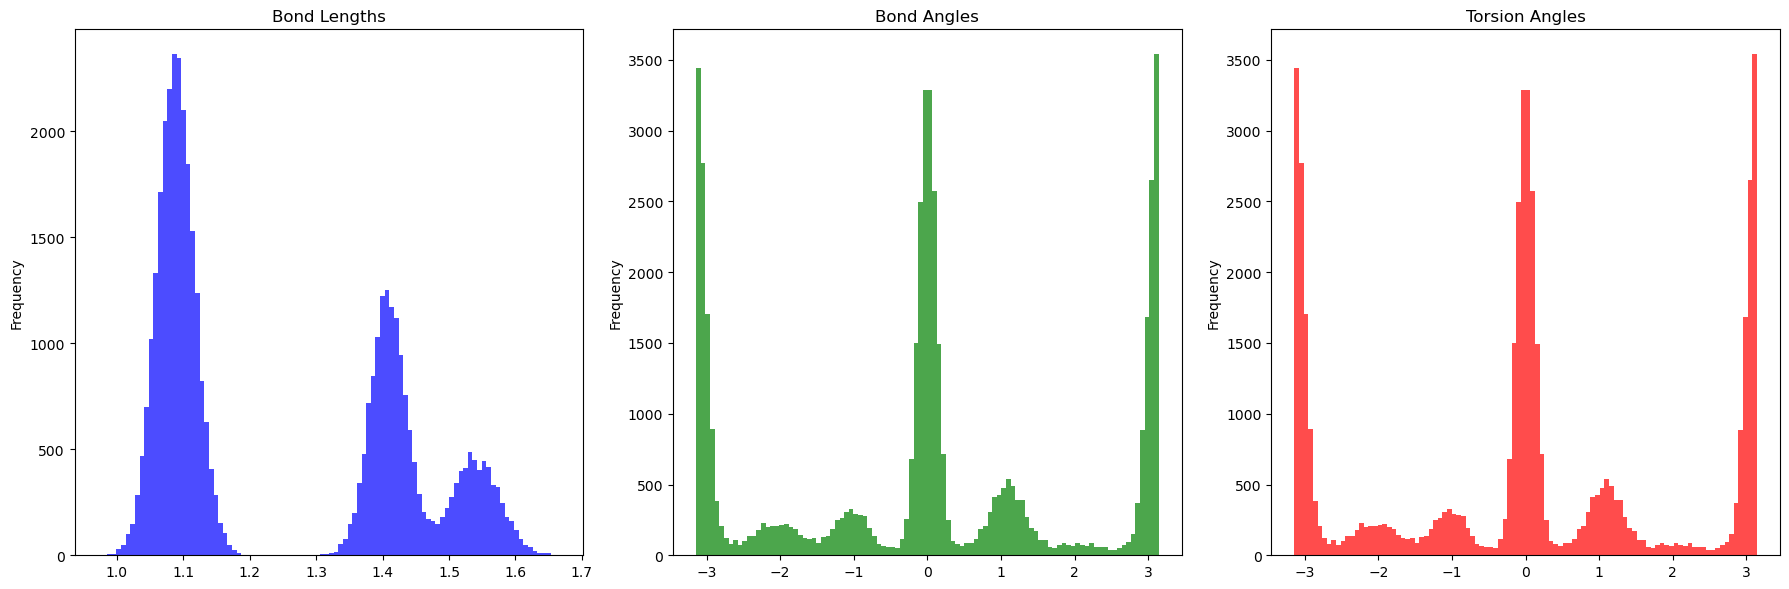

In [44]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot bond lengths histogram
axs[0].hist(bond_lengths, bins=100, color='blue', alpha=0.7)
axs[0].set_title('Bond Lengths')
axs[0].set_ylabel('Frequency')

# Plot bond angles histogram
axs[1].hist(torsion_angles, bins=100, color='green', alpha=0.7)
axs[1].set_title('Bond Angles')
axs[1].set_ylabel('Frequency')

# Plot torsion angles histogram
axs[2].hist(torsion_angles, bins=100, color='red', alpha=0.7)
axs[2].set_title('Torsion Angles')
axs[2].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
confs_md_perturbed = {}
for smi in smis:
    print('smi', smi)
    confs_md_perturbed[smi] = perturb_seeds(confs_md[smi])

smi  CC(C)c1ccccc1
torsion updates [1.84791811 1.83299609 2.02078903]
torsion updates [ 1.97826902 -1.28484628  3.05395667]
torsion updates [-2.22030922 -0.16733977 -0.32571817]
torsion updates [ 0.17198943  2.32848317 -3.07815604]
torsion updates [ 2.36693995 -1.56007625  1.73021905]
torsion updates [1.65055286 1.04620649 1.08492312]
torsion updates [ 1.6639061  -2.91309977  2.76430206]
torsion updates [-0.45392841  0.44714454  2.25829317]
torsion updates [ 1.59701683 -0.57088322  2.7027222 ]
torsion updates [-1.8044926   0.77889963 -2.20794793]
torsion updates [ 2.48056722  1.10324612 -0.77709481]
torsion updates [-2.46444256  2.59052126 -1.20065583]
torsion updates [-2.20679391  1.98125899 -0.47773312]
torsion updates [ 1.922554   -2.90837856  2.57185243]
torsion updates [ 0.36569441 -1.041853   -1.54012278]
torsion updates [-2.22851434  2.28836141 -0.11313654]
torsion updates [ 0.24606578 -1.55598712 -0.8287704 ]
torsion updates [-2.61501821 -0.82981213  2.21896334]
torsion updates

In [47]:
mols_rdkit  = {}
pos_rdkit = {}
for smi in smis:
    confs_rdkit = make_dataset_from_smi([smi for _ in range(10)])
    pos_rdkit[smi] = [x.pos.cpu().numpy() for x in confs_rdkit]
    mols_rdkit[smi] = []
    for pos in pos_rdkit[smi]:
        mol = confs_rdkit[0].mol
        new_mol = set_positions(mol, pos.astype('double')) 
        mols_rdkit[smi].append(new_mol)

In [46]:
smis

[' CC(C)c1ccccc1',
 ' C1C=CC[C@@H]2[C@@H]1C(=O)N(C2=O)SC(Cl)(Cl)Cl',
 ' CC(=CCC/C(=C/CO)/C)C',
 ' CC(=CCC[C@](C)(C=C)OC(=O)C)C',
 ' CCCCCBr',
 ' CCOP(=S)(OCC)SCSc1ccc(cc1)Cl',
 ' CCCCCCC',
 ' CC(C)(C)Br',
 ' COC(OC)OC',
 ' CC(C)C=C']

In [48]:
smi = ' C1C=CC[C@@H]2[C@@H]1C(=O)N(C2=O)SC(Cl)(Cl)Cl'
bond_lengths_mean_md, bond_angles_mean_md, torsion_angles_mean_md, bond_lengths_std_md, bond_angles_std_md, torsion_angles_std_md = get_means_and_stds_internal_coords(mols_md[smi]) 

bond_lengths_mean_rdkit, bond_angles_mean_rdkit, torsion_angles_mean_rdkit, bond_lengths_std_rdkit, bond_angles_std_rdkit, torsion_angles_std_rdkit = get_means_and_stds_internal_coords(mols_rdkit[smi]) 

In [57]:
smi   , len(mols_md[smi])

(' C1C=CC[C@@H]2[C@@H]1C(=O)N(C2=O)SC(Cl)(Cl)Cl', 2001)

In [58]:
pickle.dump(mols_md[smi], open(f'mols_md_{smi}.pkl', 'wb'))

In [54]:
for bond in mols_md[smi][0].GetBonds():
    print(bond.GetBondType(), rdMolTransforms.GetBondLength(mols_md[smi][0].GetConformer(), bond.GetBeginAtom().GetIdx(), bond.GetEndAtom().GetIdx()),  bond.GetBeginAtom().GetSymbol(),  bond.GetEndAtom().GetSymbol() )


SINGLE 1.5159120391038556 C C
DOUBLE 1.3770517082898122 C C
SINGLE 1.5317941661166259 C C
SINGLE 1.5362461374681653 C C
SINGLE 1.0536494776796836 C C
SINGLE 2.1689488270421813 C C
DOUBLE 1.121084086899562 C O
SINGLE 1.5603055548531686 C N
SINGLE 1.2315263167407255 N C
DOUBLE 2.190833402742926 C O
SINGLE 2.2540046401222207 N S
SINGLE 1.20313544979713 S C
SINGLE 3.0605518228513318 C Cl
SINGLE 3.8168974296713962 C Cl
SINGLE 3.653692386498517 C Cl
SINGLE 2.5230777206129527 C C
SINGLE 3.6059697322427327 C C
SINGLE 6.672463829223449 C H
SINGLE 7.711306138658268 C H
SINGLE 2.2491847479634424 C H
SINGLE 3.2556289908858833 C H
SINGLE 3.459449452275365 C H
SINGLE 2.246772816293391 C H
SINGLE 2.071247645454379 C H
SINGLE 2.9938521529745596 C H


In [49]:
pd.DataFrame(torch.stack([bond_lengths_mean_md, bond_lengths_mean_rdkit]).transpose(1,0))

,0,1
0,1.524875,1.503056
1,1.396968,1.336731
2,1.523457,1.500937
3,1.543646,1.497827
4,1.093624,1.530633
5,2.153909,1.471246
6,1.093548,1.270530
7,1.531014,1.438134
8,1.218822,1.442251
9,2.301438,1.265140


### Euclidean RMSD vs torsional RMSD

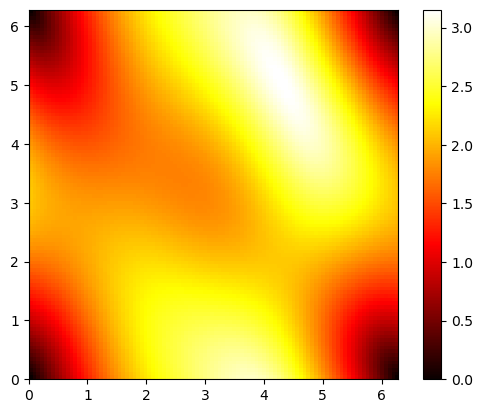

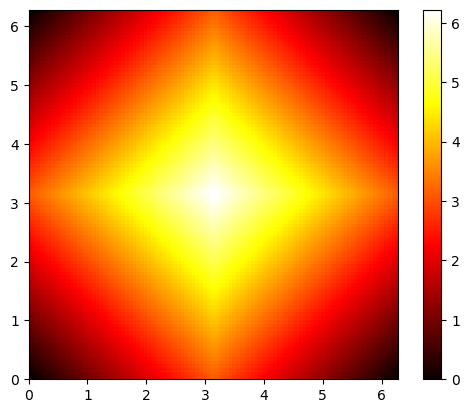

In [ ]:
dummy_data_batch = pickle.load(open('dummy_data_batch.pkl', 'rb'))
rmsds,torsion_angles_dists  = get_rmsd_torsiondist(dummy_data_batch[0] , ix0 = 0, ix1 = 1)
plt.figure() 
plt.imshow(rmsds, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', cmap='hot', interpolation='nearest')
plt.colorbar()
plt.figure()
plt.imshow(torsion_angles_dists, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', cmap='hot', interpolation='nearest')
plt.colorbar()

### Distributional shift(ground truth/ rdkit-generated data/ rdkit-generated data after confs matching) in bond lengths/bond angles 

In [25]:
ix_smi = 0
datapoint = dataset.datapoints[ix_smi]
data = copy.deepcopy(datapoint)
mols = []
for ix in range(len(data.pos)):
    data.pos, data.weights = datapoint.pos[ix], datapoint.weights[ix]
    mol = pyg_to_mol(data.mol, data, mmff=False, rmsd=True, copy=True)
    mols.append(mol)

get_stds_internal_coords(mols)

(tensor(0.0150), tensor(0.0328), tensor(1.5765))

In [9]:
mols_gen = list(conformers_gen.values())[0]
get_stds_internal_coords(mols_gen)

(tensor(0.0159), tensor(0.0701), tensor(1.5332))

In [10]:
bond_angles = [get_bond_angles(mol) for mol in mols]
bond_angles_gen = [get_bond_angles(mol)[:-1] for mol in mols_gen]
torch.stack(bond_angles + bond_angles_gen).std(dim=0).mean()

tensor(0.1286)

In [11]:
bond_lengths = [get_bond_lengths(mol) for mol in mols]
bond_lengths_gen = [get_bond_lengths(mol) for mol in mols_gen]
torch.stack(bond_lengths + bond_lengths_gen).std(dim=0).mean()

tensor(0.0986)

Hm, the std deviation of bond lengths&bond angles increases when we concatenate [mols_ground truth, mols_gen]. which seems to indicate a distributional shift in the lengths/angles distributions when we are moving from gt to rdkit-generated. Does this explain the energy-shifts?

Hmmmm, interesting, the torsion angles change a lot with relaxation. But why does relaxation need to go so far in terms of RMSD? Why doesn't it go to the closest 'ground-truth' conformer?

Well, if we look at the eval metrics for this set of molecules: 

 - threshold 0.75:

- Recall Coverage: Mean = 61.66, Median = 82.02

- Recall AMR: Mean = 0.6300, Median = 0.5793

- Precision Coverage: Mean = 35.80, Median = 42.31

- Precision AMR: Mean = 0.9013, Median = 0.7905

The precision AMR is around 0.9, i.e. it is the same order of magnitude of relaxtion. So the results with relaxation are not that surprising


**Training conformers after conformer matching have low energy!** Ca laisse penser que c'est le modele qui est pas assez bon

        - Plot : bond lengths and angles distribution of training conformers after confs matching. Ot has very low variance, so it makes sense to fix bond lengths/angles, and it's the diff model that is pretty bad
       
        - How does this energy compare to the energy of conformers **before confs matching?** -> voir si ça vaut vraiment le coup de fixer les bond lengths/angles ou pas

### Impact of fixing the bond lengths/angles on the energy

In [ ]:
import random

all_energies_before = []
all_energies_after = []

for smi_idx in tqdm(range(len(dataset))): 
#random.sample(range(0, len(dataset)), n_smis)
#for smi_idx in range(0, n_smis):   
    confs = get_gt_confs(dataset, smi_idx)
    mols = [pyg_to_mol(conf.mol, conf, mmff=False, rmsd=False, copy=True) for conf in confs]
    energies_before = [mmff_energy(mol) for mol in mols]
    energies_after = []
    for mol in mols:
        mol = set_bond_lengths(mol, mols[-1])
        mol = set_bond_angles(mol, mols[-1])
        energies_after.append(mmff_energy(mol))
    all_energies_before.append(energies_before)
    all_energies_after.append(energies_after)


100%|██████████| 9295/9295 [13:56<00:00, 11.12it/s]


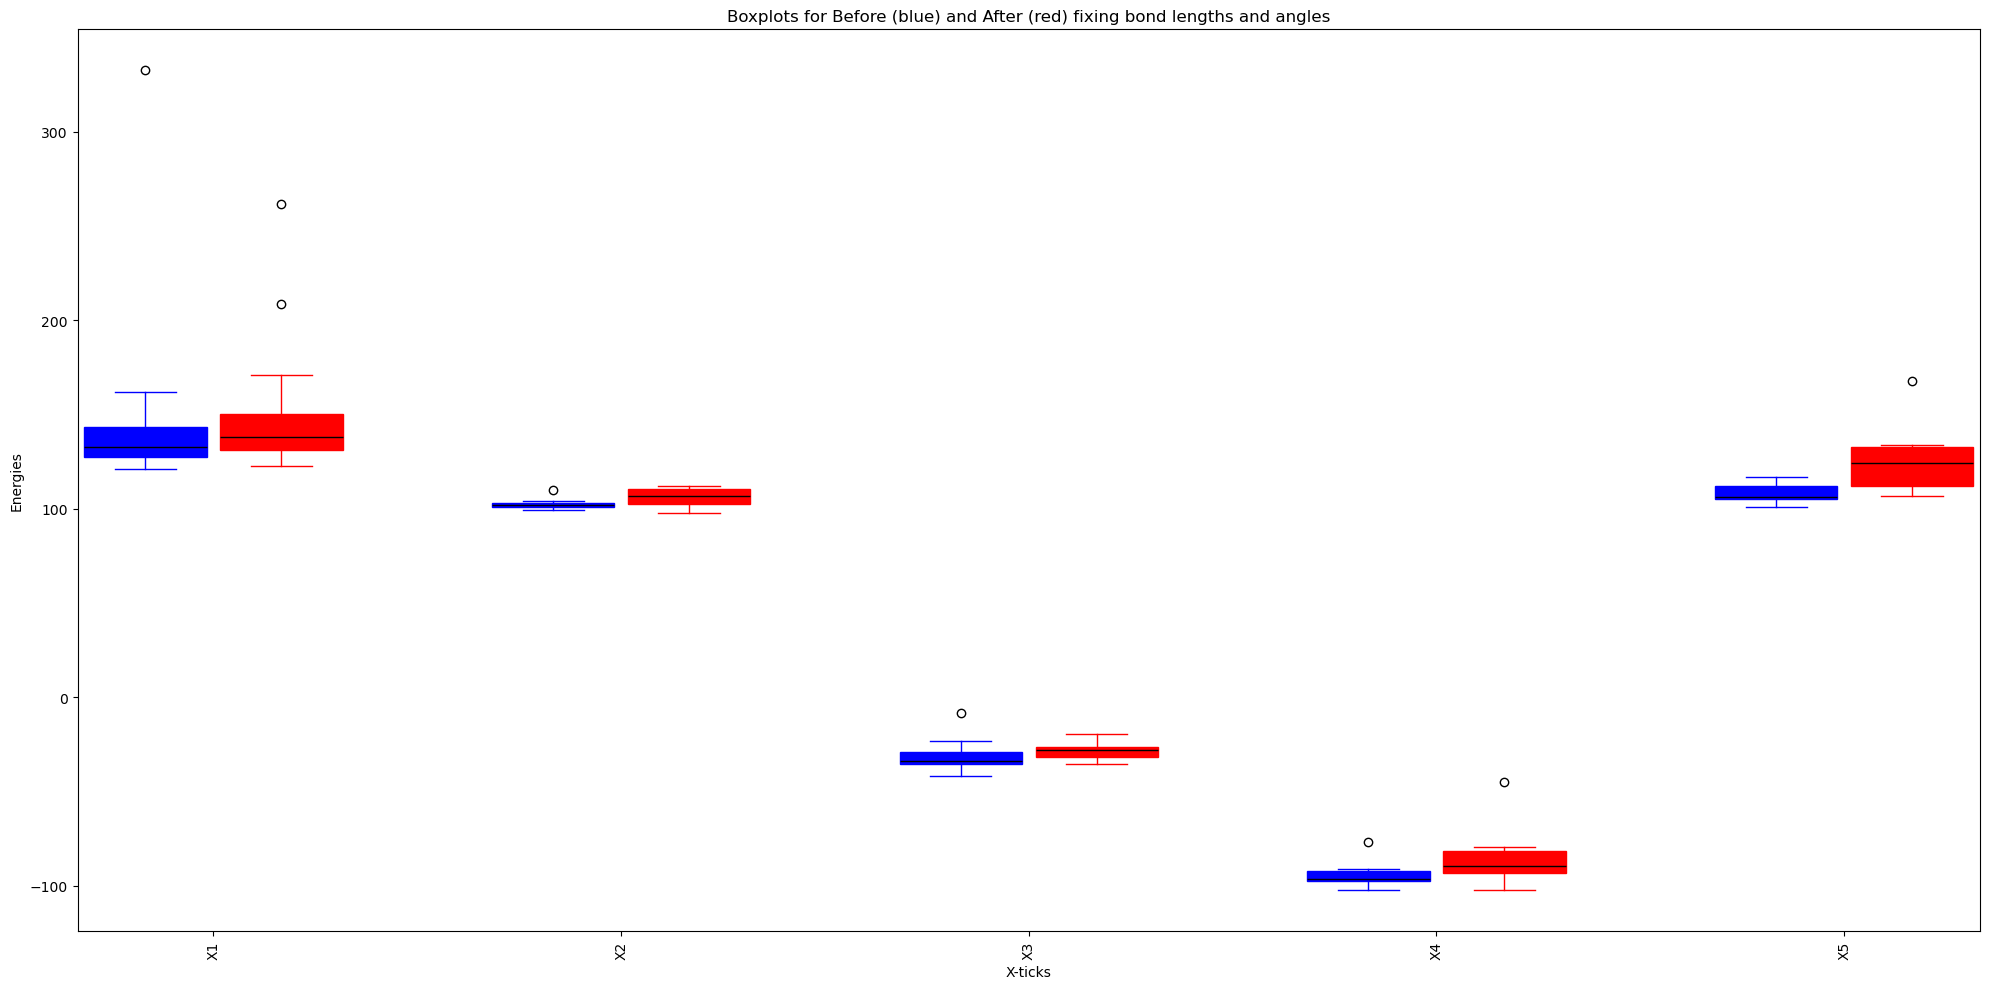

In [ ]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(20, 10))
n_smis = 5
# Plot the boxplots
positions = np.arange(1, 3* n_smis + 1, 3)  # Positions for 'before' boxplots
for i in range(n_smis):
    ax.boxplot(all_energies_before[i], positions=[positions[i]], widths=0.9,  patch_artist=True,
               boxprops=dict(facecolor='blue', color='blue'),
               medianprops=dict(color='black'),
               whiskerprops=dict(color='blue'),
               capprops=dict(color='blue'))

    ax.boxplot(all_energies_after[i], positions=[positions[i ] + 1], widths=0.9, patch_artist=True,
               boxprops=dict(facecolor='red', color='red'),
               medianprops=dict(color='black'),
               whiskerprops=dict(color='red'),
               capprops=dict(color='red'))

# Customize x-ticks
ax.set_xticks(positions + 0.5)
ax.set_xticklabels([f'X{i+1}' for i in range(n_smis)], rotation=90)

# Set labels and title
ax.set_xlabel('X-ticks')
ax.set_ylabel('Energies')
ax.set_title('Boxplots for Before (blue) and After (red) fixing bond lengths and angles')
# Display the plot
plt.tight_layout()
plt.show()

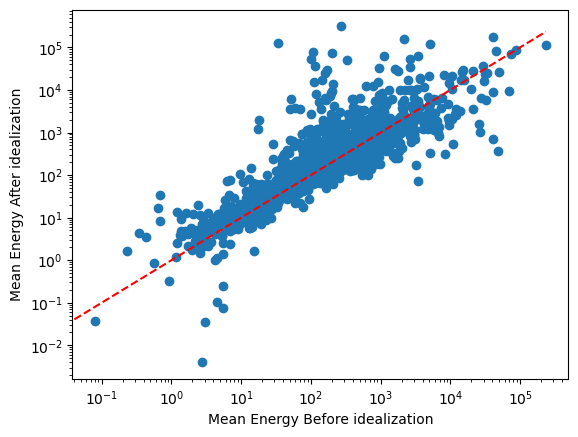

In [ ]:
energies_before_means = [np.mean(x) for x in all_energies_before]
energies_after_means = [np.mean(x) for x in all_energies_after]

plt.scatter(energies_before_means, energies_after_means)
plt.xlabel('Mean Energy Before idealization')
plt.ylabel('Mean Energy After idealization')
plt.xscale('log')

plt.plot([min(energies_before_means), max(energies_before_means)], 
         [min(energies_before_means), max(energies_before_means)], 
         color='red', linestyle='--')
plt.yscale('log')
plt.show()


TODO: after the deadline, look into outliers of this plot

### Test for xtb energy code (both code in torsional_diff repo and Sasha's code)

In [8]:
data = next(iter(loader))
data

DataBatch(x=[32, 74], edge_index=[2, 70], edge_attr=[70, 4], z=[32], canonical_smi=[1], mol=[1], pos=[30], weights=[1], edge_mask=[70], mask_rotate=[1], batch=[32], ptr=[2])

In [15]:
from utils.xtb import xtb_energy

for i in range(len(data[0].pos)):
    data0 = copy.deepcopy(data[0])
    data0.pos = data[0].pos[i]
    mol = pyg_to_mol(data0.mol, data0, copy=True)
    print(f'Energy {i} {xtb_energy(mol, path_xtb = "/home/mila/l/lena-nehale.ezzine/ai4mols/torsional-diffusion/xtb" )}')

xtb_energy did not converge
Energy 0 {}
xtb_energy did not converge
Energy 1 {}
xtb_energy did not converge
Energy 2 {}
xtb_energy did not converge
Energy 3 {}
xtb_energy did not converge
Energy 4 {}
xtb_energy did not converge
Energy 5 {}
xtb_energy did not converge
Energy 6 {}
xtb_energy did not converge
Energy 7 {}
xtb_energy did not converge
Energy 8 {}
xtb_energy did not converge
Energy 9 {}
xtb_energy did not converge
Energy 10 {}
xtb_energy did not converge
Energy 11 {}
xtb_energy did not converge
Energy 12 {}
xtb_energy did not converge
Energy 13 {}
xtb_energy did not converge
Energy 14 {}
xtb_energy did not converge
Energy 15 {}
xtb_energy did not converge
Energy 16 {}
xtb_energy did not converge
Energy 17 {}
xtb_energy did not converge
Energy 18 {}
xtb_energy did not converge
Energy 19 {}
xtb_energy did not converge
Energy 20 {}
xtb_energy did not converge
Energy 21 {}
xtb_energy did not converge
Energy 22 {}
xtb_energy did not converge
Energy 23 {}
xtb_energy did not converg

In [9]:
import contextlib
import os
import re
import subprocess
import warnings

import numpy as np


def _get_energy(file):
    normal_termination = False
    with open(file) as f:
        for l in f:
            if "TOTAL ENERGY" in l:
                try:
                    energy = float(re.search(r"[+-]?(?:\d*\.)?\d+", l).group())
                except:
                    return np.nan
            if "normal termination of xtb" in l:
                normal_termination = True
    if normal_termination:
        return energy
    else:
        return np.nan


def run_gfn_xtb(
    filepath,
    filename,
    gfn_version="gfnff",
    opt=False,
    gfn_xtb_config: str = None,
    remove_scratch=True,
):
    """
    Runs GFN_XTB/FF given a directory and either a coord file or all coord files will be run

    :param filepath: Directory containing the coord file
    :param filename: if given, the specific coord file to run
    :param gfn_version: GFN_xtb version (default is 2)
    :param opt: optimization or single point (default is opt)
    :param gfn_xtb_config: additional xtb config (default is None)
    :param remove_scratch: remove xtb files
    :return:
    """
    xyz_file = os.path.join(filepath, filename)

    # optimization vs single point
    if opt:
        opt = "--opt"
    else:
        opt = ""

    # cd to filepath
    starting_dir = os.getcwd()
    os.chdir(filepath)

    file_name = str(xyz_file.split(".")[0])
    cmd = "xtb --{} {} {} {}".format(
        str(gfn_version), xyz_file, opt, str(gfn_xtb_config or "")
    )

    # run XTB
    with open(file_name + ".out", "w") as fd:
        subprocess.run(cmd, shell=True, stdout=fd, stderr=subprocess.STDOUT)

    # check XTB results
    if os.path.isfile(os.path.join(filepath, "NOT_CONVERGED")):
        # optimization not converged
        warnings.warn(
            "xtb --{} for {} is not converged, using last optimized step instead; proceed with caution".format(
                str(gfn_version), file_name
            )
        )

        # remove files
        if remove_scratch:
            os.remove(os.path.join(filepath, "NOT_CONVERGED"))
            os.remove(os.path.join(filepath, "xtblast.xyz"))
            os.remove(os.path.join(filepath, file_name + ".out"))
        energy = np.nan

    elif opt and not os.path.isfile(os.path.join(filepath, "xtbopt.xyz")):
        # other abnormal optimization convergence
        warnings.warn(
            "xtb --{} for {} abnormal termination, likely scf issues, using initial geometry instead; proceed with caution".format(
                str(gfn_version), file_name
            )
        )
        if remove_scratch:
            os.remove(os.path.join(filepath, file_name + ".out"))
        energy = np.nan

    else:
        # normal convergence
        # get energy
        energy = _get_energy(file_name + ".out")
        if remove_scratch:
            with contextlib.suppress(FileNotFoundError):
                os.remove(os.path.join(filepath, file_name + ".out"))
                os.remove(os.path.join(filepath, "gfnff_charges"))
                os.remove(os.path.join(filepath, "gfnff_adjacency"))
                os.remove(os.path.join(filepath, "gfnff_topo"))
                os.remove(os.path.join(filepath, "xtbopt.log"))
                os.remove(os.path.join(filepath, "xtbopt.xyz"))
                os.remove(os.path.join(filepath, "xtbtopo.mol"))
                os.remove(os.path.join(filepath, "wbo"))
                os.remove(os.path.join(filepath, "charges"))
                os.remove(os.path.join(filepath, "xtbrestart"))
    os.chdir(starting_dir)
    return energy

In [10]:
import numpy as np
import numpy.typing as npt
import torch
from joblib import Parallel, delayed
from torch import Tensor
from wurlitzer import pipes
from tempfile import TemporaryDirectory
from pathlib import Path

def _write_xyz_file(
    elements: npt.NDArray, coordinates: npt.NDArray, file_path: str
) -> None:
    num_atoms = len(elements)
    with open(file_path, "w") as f:
        f.write(str(num_atoms) + "\n")
        f.write("\n")

        for i in range(num_atoms):
            element = elements[i]
            x, y, z = coordinates[i]
            line = f"{int(element)} {x:.6f} {y:.6f} {z:.6f}\n"
            f.write(line)


def get_energy(numbers, positions, method="gfnff"):
    directory = TemporaryDirectory()
    file_name = "input.xyz"

    _write_xyz_file(numbers, positions, str(Path(directory.name) / "input.xyz"))
    with pipes():
        energy = run_gfn_xtb(directory.name, file_name, gfn_version=method)
    directory.cleanup()

    if np.isnan(energy):
        return 0.0

    return energy

In [17]:
numbers = np.array(data.z )
for i in range(len(data.pos)):
    positions = data.pos[i].cpu().numpy() * 1.88973 # Convert angstrom to bohr
    print('xtb energy', get_energy(numbers, positions, method="gfnff"))
    # Get mmff energy
    data0 = copy.deepcopy(data[0])
    data0.pos = data.pos[i]
    mol = pyg_to_mol(data0.mol, data0, copy=True)
    print('mmff energy', mmff_energy(mol))

xtb energy 0.0
mmff energy 121.3116009195142
xtb energy 0.0
mmff energy 122.86134879363988


xtb energy 0.0
mmff energy 161.6486340640398
xtb energy 0.0
mmff energy 125.2604098036516
xtb energy 0.0
mmff energy 128.70566894271877
xtb energy 0.0
mmff energy 153.76089445331627
xtb energy 0.0
mmff energy 332.43989204944984
xtb energy 0.0
mmff energy 121.47693468083162
xtb energy 0.0
mmff energy 144.12324823583413
xtb energy 0.0
mmff energy 124.45701224428865
xtb energy 0.0
mmff energy 132.8055856825035
xtb energy 0.0
mmff energy 132.43307647931928
xtb energy 0.0
mmff energy 141.5042334805122
xtb energy 0.0
mmff energy 127.24921893627723
xtb energy 0.0
mmff energy 129.14555094835276
xtb energy 0.0
mmff energy 141.03716623299175
xtb energy 0.0
mmff energy 153.13854042078646
xtb energy 0.0
mmff energy 153.08036970382176
xtb energy 0.0
mmff energy 135.37674077455193
xtb energy 0.0
mmff energy 134.6181202849798
xtb energy 0.0
mmff energy 141.6416562461666
xtb energy 0.0
mmff energy 130.88865207375883
xtb energy 0.0
mmff energy 160.87546824245996
xtb energy 0.0
mmff energy 129.102265614